<a href="https://colab.research.google.com/github/HMR1998/Laptop-Brands/blob/main/laptop_brand_model_dt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline
import seaborn as sns

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
sns.set()

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn import metrics

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/Laptop_brands/model_data')

In [3]:
cat_data = ['brand', 'Model', 'processor_brand', 'processor_tier', 'gpu_type', 'OS']

label_encoder = LabelEncoder()

for col in cat_data:
  df[col + '_encoded'] = label_encoder.fit_transform(df[col])

df['price_in_log'] = df['Price'].apply(np.log)

df = df.drop(columns=cat_data)
df = df.drop(columns='number')

In [4]:
df.head()

,Price,Rating,num_cores,num_threads,ram_memory,primary_storage_capacity,display_size,resolution_width,resolution_height,brand_encoded,Model_encoded,processor_brand_encoded,processor_tier_encoded,gpu_type_encoded,OS_encoded,price_in_log
0,239.9,63,2,4,8,512,15.6,1920,1080,21,970,2,1,2,6,5.480222
1,359.9,67,4,8,16,1024,15.6,1920,1080,21,971,2,3,2,6,5.885826
2,511.0,73,6,12,8,512,15.6,1920,1080,10,620,0,12,1,6,6.236370
3,399.9,62,12,16,8,512,14.0,1920,1080,0,55,2,2,2,6,5.991215
4,285.8,62,4,8,8,512,15.6,1920,1080,14,838,0,11,2,6,5.655292


In [5]:
X = df.iloc[:,1:8]
y = df.iloc[:,15]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=44)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=44)

In [6]:
class ModelTrainAndTest:

  def __init__ (self, model):
    self.model = model


  def training(self, X_t, y_t):
    self.model.fit(X_t, y_t)
    return self.model


  def validation(self, X_v):
    y_p = self.model.predict(X_v)
    return y_p


  def hyperparameter_training(self, X_t, y_t, p, scr, cv, verb):
    tuned_model = GridSearchCV(self.model, param_grid=p, scoring=scr,
                               cv=cv, verbose=verb)

    tuned_model.fit(X_t, y_t)
    self.tuned_model = tuned_model
    return tuned_model.best_params_


  def hyperparameter_validation(self, X_v):
    y_p = self.tuned_model.predict(X_v)
    return y_p


  def testing(self, X_t):
    y_p = self.model.predict(X_t)
    return y_p


  def evaluation_metrics(self, y_v, y_p):
    mae = metrics.mean_absolute_error(y_v, y_p)
    mse = metrics.mean_squared_log_error(y_v, y_p)
    rmse = np.sqrt(metrics.mean_squared_log_error(y_v, y_p))

    return mae,mse,rmse

In [7]:
dt = DecisionTreeRegressor()

dt_model = ModelTrainAndTest(dt)
dt_model.training(X_train, y_train)

y_pred = dt_model.validation(X_val)

mae, mse, rmse = dt_model.evaluation_metrics(y_val, y_pred)
print(f'MAE = {mae}')
print(f'MSE = {mse}')
print(f'RMSE = {rmse}')

MAE = 0.1993356775936806
MSE = 0.0012012194301729145
RMSE = 0.034658612640625336


In [8]:
path = dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

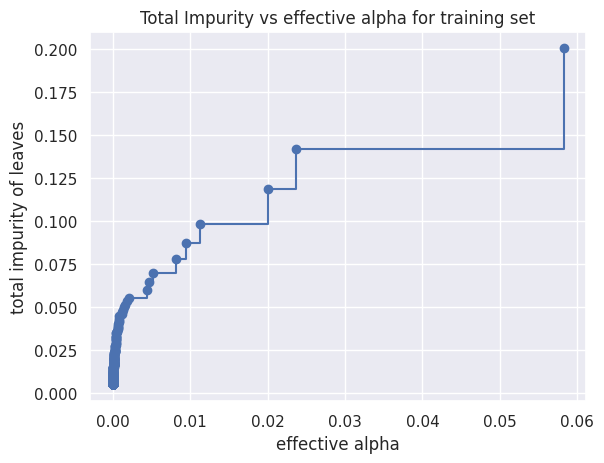

In [9]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [10]:
parameters={"splitter":["best","random"],
            "max_depth" : [None,1],
           "min_samples_leaf":[1,9],
           "min_weight_fraction_leaf":[0.0, 0.1],
           "max_features":["log2", None],
           "max_leaf_nodes":[None,40],
            "ccp_alpha": [0.0, 0.003]}

dt_model.hyperparameter_training(X_train, y_train, parameters, 'neg_mean_squared_log_error',
                                 5, 1)
hyper_pred = dt_model.hyperparameter_validation(X_val)
mae, mse, rmse = dt_model.evaluation_metrics(y_val, hyper_pred)
print(f'MAE = {mae}')
print(f'MSE = {mse}')
print(f'RMSE = {rmse}')

Fitting 5 folds for each of 128 candidates, totalling 640 fits
MAE = 0.18773562797019908
MSE = 0.0010709961192364827
RMSE = 0.03272607705235204


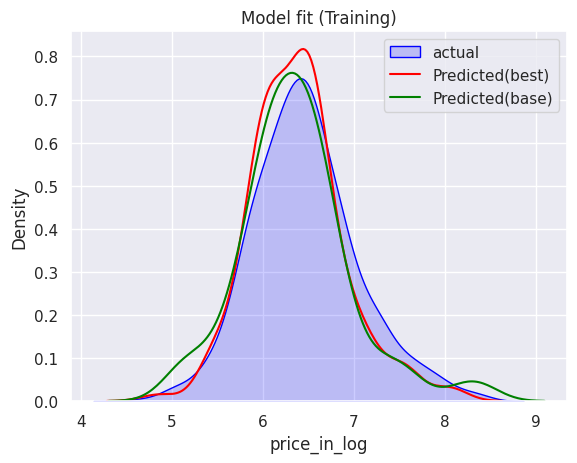

In [11]:
fig = figsize =(10,8)

sns.kdeplot(data=df, x='price_in_log', fill=True,
            alpha=0.2,color='blue', label='actual')
sns.kdeplot(hyper_pred, color='red', label='Predicted(best)')
sns.kdeplot(y_pred, color='green', label='Predicted(base)')

plt.legend(loc='upper right')
plt.title('Model fit (Training)')

plt.show()

In [12]:
test_pred = dt_model.testing(X_test)
mae, mse, rmse = dt_model.evaluation_metrics(y_test, test_pred)
print(f'MAE = {mae}')
print(f'MSE = {mse}')
print(f'RMSE = {rmse}')

MAE = 0.20889021247451472
MSE = 0.001655334139437501
RMSE = 0.040685797760858775


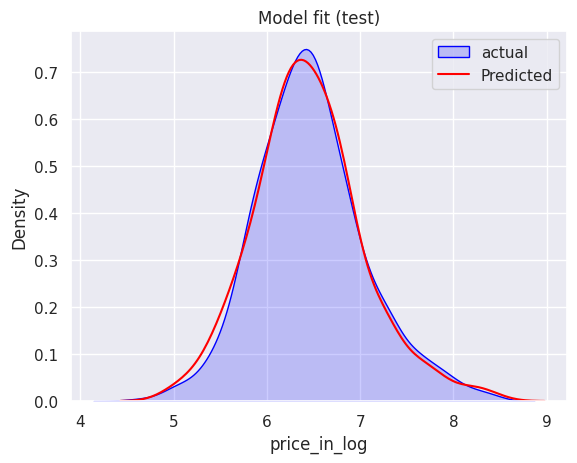

In [14]:
fig = figsize =(10,8)

sns.kdeplot(data=df, x='price_in_log', fill=True,
            alpha=0.2,color='blue', label='actual')
sns.kdeplot(test_pred, color='red', label='Predicted')

plt.legend()
plt.title('Model fit (test)')

plt.show()